1. **Guidance scale:** This specifies to what degree the model should be focusing on the specific caption vs. just creating ANY image. The model creates 2 images - one with the prompt and one without the prompt (i.e., a completely random image). And then it takes a weighted average of those two images. You can think of the guidance scale as a bit like the weight used to compute the weighted average.

2. **Negative prompt:** Again, we ask the model to create two images. But this time, we ask the model to subtract one from the other.

**Note:** The details of guidance scale and negative prompt are slightly different from what's described above. But those are the approximate ideas.

3. **Image-to-image:** Rather than starting the diffusion process with random noise, we ask the model to start with a noisy version of the input image. The model gets guidance from both the prompt and the input image. The `strength` argument specifies to what degree we want the model to stick to the original image's concept ("composition") vs. trying out different things. **Note:** You can use the output of the image-to-image pipeline as a subsequent input to the image-to-image pipeline.

4. For **fine-tuning** stable diffusion, one clever idea to create a dataset is the following: Grab an image dataset, and then generate captions for them using an image captioning model (e.g., BLIP). Or maybe use GPT4 / Gemini to generate captions.

**Note:** Fine-tuning can take quite a bit of data (e.g., a few hundred images) and quite a bit of time. But you can actually do some special kinds of fine-tuning, e.g., textual inversion & DreamBooth.

5. **Textual inversion:** Here, we fine-tune a single embedding, i.e., the embedding vector for a single token. For example, the new token `"<watercolor-portrait>"` corresponds to an image dataset of Indian watercolor portraits (containing only 4 images). We then add that token to the text encoder's vocabulary, adjust the embedding size, and train the embeddings for JUST the newly added token in a way that it matches the 4 example images. This is very fast, because we're just training a single token. After this, if we use the prompt `"Woman reading in the style of <watercolor-portrait>"`, Stable Diffusion is able to transfer the style of the 4 images to newly generated images.

**Warning:** As far as my knowledge goes, it's impossible to train the embedding vector for a single token. In PyTorch, `requires_grad` is typically set at a `torch.Tensor` level. Alternatively, you can wrap the tensor with `nn.Parameter`, and `requires_grad=True` will be set automatically for that tensor. This means that we can't really freeze some rows of an embedding matrix, and keep the other rows unfrozen. We either freeze the whole tensor, or keep it unfrozen. In the 'stable_diffusion.ipynb' notebook (in the 'diffusion-nbs' repo), it's mentioned:

> "freezing the weights of all the modules (except the text encoder)"

This is conflicting with what was mentioned in the Lesson 9 video - "*we fine-tune a single embedding*". It also raises a question. Do we keep the full text encoder unfrozen, or just the input embedding matrix of the text encoder unfrozen?

**Perhaps this is what's being done:** We fine-tune the whole text encoder, but ultimately extract only the embedding vector of the newly added token from the text encoder. Then we add this embedding vector to the original Stable Diffusion model, and run inference. You can re-visit & confirm these details in your second run through course22p2.

**Note:**

- Textual inversion is a great choice for doing style transfer, when the dataset containing the new style (that you want the model to learn) has very few images.
- "Tiny" is the name of a teddy bear with a corresponding set of images. Jeremy performed textual inversion for the token `"<tiny>"`. And then tried to use the prompt `"<tiny> riding a horse"`. But this failed. Instead of learning the concept of "Tiny" (a teddy bear), the model learned the style of "Tiny", and produced a horse whose texture & shape were a bit like a teddy bear's.

6. **DreamBooth** is a technique to put any object / person into an image. It works similar to textual inversion, except that we don't add a new token. Rather, we find an existing uncommon (rarely used) token, create a correspondence (mapping) from **a single prompt containing that uncommon token** to a small set of new images. Then we fine-tune the full model. The objective is to overfit the prompt to the set of new images. A key difference is that in DreamBooth, all the parameters are unfrozen during the fine-tuning process. (We don't fine-tune JUST the text encoder; we fine-tune the full model.)

**Note:** From DreamBooth's Jeremy photos, it seems that DreamBooth is able to learn concepts. Whereas from the `"<watercolor-portrait>"` and the "Tiny" teddy bear textual inversion examples, it **seems** that textual inversion is able to learn only styles.

7. The way Stable Diffusion is usually explained is focused on a particular mathematical derivation. Jeremy has been developing a totally new way of thinking about Stable Diffusion, which is what he will teach. Both the formulations are mathematically equivalent. Jeremy's approach is conceptually much simpler. When you think of it in this brand new way, it can take you in some innovative research directions.

8. The first function (`f`) he mentions: it outputs the probability that an image is a handwritten digit. Why not just create a binary classification model (with a single output unit & a sigmoid activation function)? The model can be trained using MNIST (handwritten digits) & Fashion-MNIST (not handwritten digits)! According to Jeremy, if we have this function, we can actually use it to generate handwritten digits. **Note:** With the MNIST, Fashion-MNIST approach, you don't have to start with random noise to perform gradient ascent.

9. How to achieve the above: Take a noisy image. Then for each pixel, see whether it can be made a little bit darker or a little bit lighter to **increase** the probability of it being a handwritten digit. If we vectorize this, what we have is gradient **ascent**, where 'gradient' refers to the gradient of the probability function w.r.t. the pixels of a particular input image, e.g., `X_3` mentioned in the video (not w.r.t. the model parameters). Alternatively, you could stick a minus sign in front of the `f` function, and then perform gradient descent.

**Note:** For `f.backward()` and `X_3.grad` to work, we need `X_3` to have `requires_grad=True`. But `X_3` is an image (an input tensor with `requires_grad=False`), not an `nn.Parameter` with `requires_grad=True`. So how would that work? A hack might be: after the model is trained, freeze all it's parameters. Then set `requires_grad=True` for the input tensor. And do a forward pass without using the `torch.no_grad()` context manager. Then you might be able to get the gradient of `f` w.r.t. `X_3`?

10. The gradient function of the function `f` w.r.t. an image (say `X_3`), i.e., `X_3.grad` is often called the '*score function*'.

11. Partial derivatives of a multi-variate function:

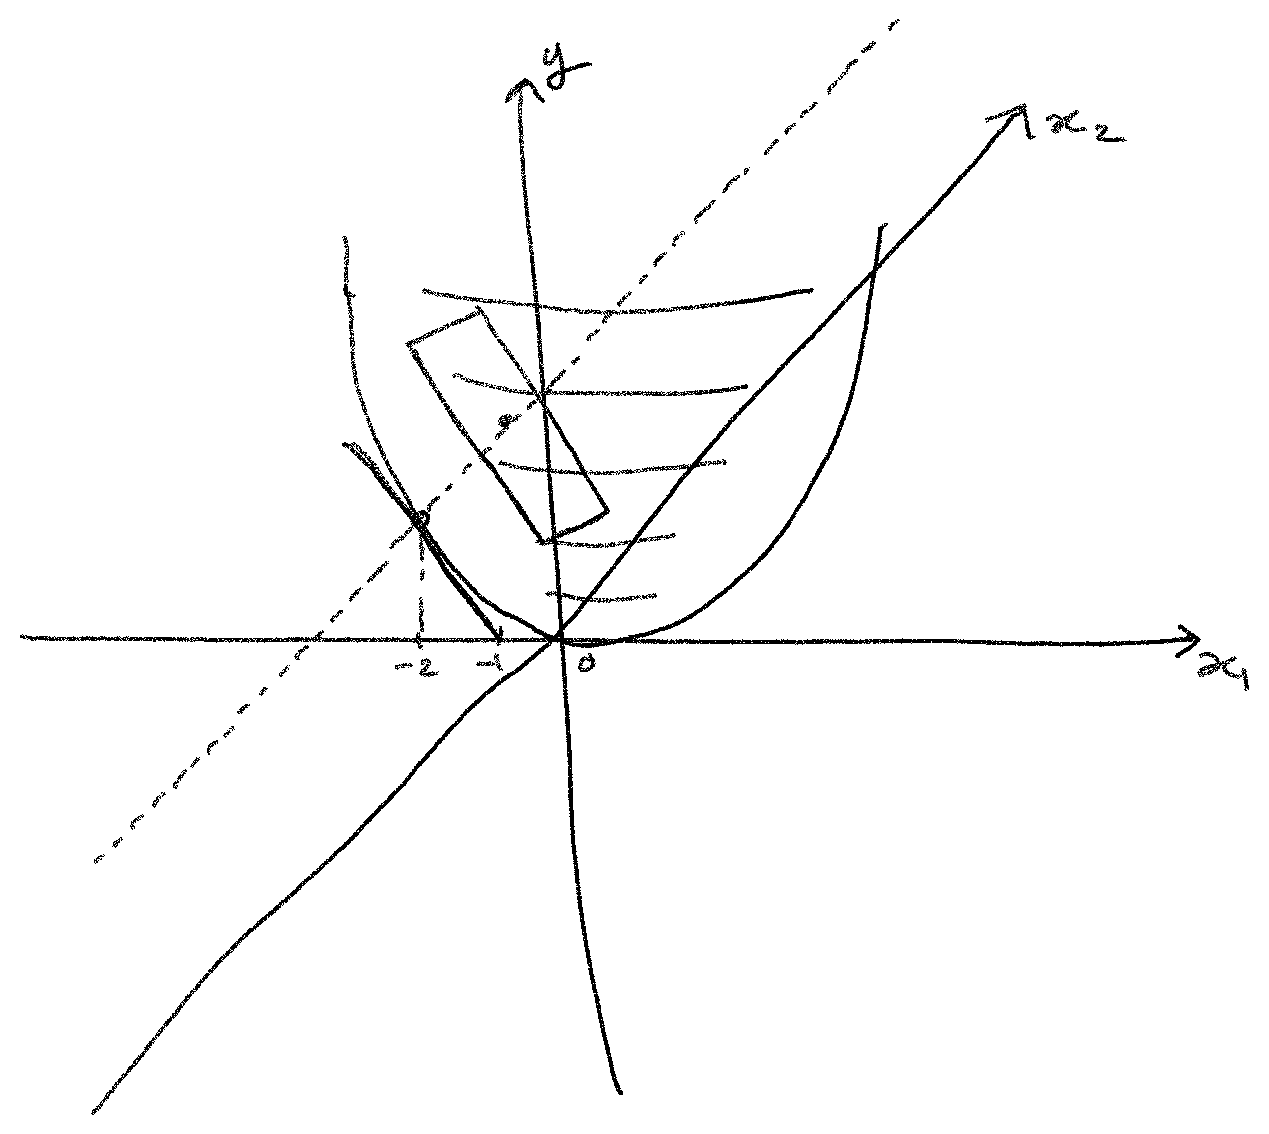

Here, $y = f(x_1, x_2)$. The partial derivative at $x_1 = -2$ and $x_2 = 0$ is shown as the point where a tangent touches the bowl shaped function $f(x_1, x_2)$. **Note:** Since we're operating in 3D now, the tangent is actually a plane, not a line. (This is not apparent at $x_1 = -2$ and $x_2 = 0$, because we're looking at the plane from the side). The partial derivative (as an expression) is a function of both $x_1$ and $x_2$. The fact that the slope of the tangent changes as we change $x_1$ is obvious. However, it also changes as we change $x_2$. For example, at $x_1 = -2$, $x_2$ changes along the dashed line parallel to the $x_2$ axis. One of those tangent planes is represented as a quadrilateral in the diagram. (Think of the quadrilateral as facing you.)

12. **Fine differencing** method of calculating derivatives: When you change the input by a tiny bit, calculate the change in the output, and then take the ratio of the change in output to the change in input. This is very slow because we have to call the function `n_inputs + 1` number of times. For example, if a model has 1,000 parameters, we have to do 1,001 forward passes (See "Finite Difference Approximation" in Appendix B of Aurelien Geron's book.) So instead, we use reverse-mode autodiff.

13. An alternative to estimating the function `f` and calculating its gradient w.r.t. an input image: We could use a neural network that tells us how much to change each pixel of an image to make it more like a handwritten digit. To do this, we could create some training data, comprising of images that look (i) exactly like a handwritten digit, (ii) somewhat like a handwritten digit, (iii) not at all like a handwritten digit, etc. We could create these images by taking actual handwritten digits, and adding random noise to them. Then, we could train a UNet to predict how much noise we added. So in this approach, the amount of noise tells us how much like a handwritten digit each image is. We can subtract the noise from the noisy image to make it more like a handwritten digit. **Question:** But how will this work if we start with pure noise? Won't it predict that '*everything*' is noise? **Answer:** Yes (for unconditional Stable Diffusion). But as you'll see later, we also provide the UNet a vectorized prompt (conditional Stable Diffusion). This provides the model *guidance*, and it doesn't predict that '*everything*' is noise any more.

14. The above UNet is the first component of Stable Diffusion. **Note:** The loss function for training the UNet can simply be MSE, where the targets are the actual noises (784 of them - one for each pixel), and the predictions are the predicted noises (784 of them - one for each pixel).

15. There is a problem. In MNIST, there are 28x28 (784) input pixels. But in real life, the images are much larger, especially if they are HD images - often used for artwork / photography. Creating noisy versions of millions of such large images (for training our UNet), and then training our UNet on millions of these large images is going to take a very long time! At the moment, the image size we input to Stable Diffusion is `(3, 512, 512)`. So there are a total of 3 * 512 * 512 = 786,432 bytes - each pixel value ranging from 0 to 255 takes up one byte (8 bits). This is also the reason why (as a design decision), computer scientists decided that pixel values would range from 0 to 255 - because the binary representation of 255 is 11111111 - the largest number possible to represent using a single byte.

16. Jeremy says that we can pass the `(24, 64, 64)` image tensor through a few residual blocks to reduce the number of channels (as much as we can) & obtain a `(4, 64, 64)` image tensor. But in Ch 8 of the "Deep Learning with PyTorch" book, the residual blocks returned a tensor with the same image size AND the same number of channels. This is what allowed us to create a skip connection by adding the input `x` to the output `out`. Is there a way to reduce the number of channels by using residual blocks? Then how will the addition of `x` and `out` work? I guess you'll have to wait for the ResNet lesson in this course to find out.

17. By using an autoencoder (specifically a variational autoencoder - a VAE), we can reduce the number of bytes from 786,432 to 4 * 64 * 64 = 16,384 bytes (for example) - a 48x decrease.

18. We can train an autoencoder using the MSE loss (for example). If we do so, each predicted pixel will be compared to each ground truth pixel for loss computation. If the autoencoder is able to reproduce the input image exactly, then the MSE will be zero. **Note:** An autoencoder may seem to have a similar architecture to a UNet. But its architecture is actually different. There are no cross-connections.

19. The encoder part of an autoencoder is a compression algorithm, and the decoder part is a decompression algorithm. You can cut out the encoder and the decoder from the neural network. You can compress an image with the encoder, and send the compressed image tensor to your friend over an email. Then your friend can use the decoder to decompress the image tensor and get back the original image. **Note:** These compression and decompression algorithms work extremely well. The compressed version of an image is called a '*latent*'.

20. If the latent contains all the useful information about the image, why on earth would we train our UNet using images that are 48x larger? Well, we won't. Instead, we'll train the UNet to take a noisy latent as input and predict the noise. Then, we'll subtract the noise (multiplied by some constant - akin to a learning rate) from the noisy latent to obtain a de-noised latent.

21. You need the encoder of an autoencoder when training a UNet (to compress the training set images). If you simply want to perform Stable Diffusion inference, you only need the decoder of the autoencoder. The reason is: when performing Stable Diffusion inference, we start with a noisy latent (e.g., a latent comprising pure noise), and ask the UNet to predict the noise. We subtract the noise (multiplied by some constant) from the noisy latent to get the de-noised latent. Then, we pass the de-noised latent through the autoencoder's decoder to obtain a diffused image. **Note:** For the image-to-image pipeline, you'll probably need the autoencoder's encoder to compress the image into a latent, add some noise to it, and then continue the diffusion process using the noisy latent as a starting point.

22. The only reason for using the VAE is to save compute. If we had infinite compute, then we could have trained a UNet on the original images (instead of on the latents).

23. For conditional Stable Diffusion, we want to give the model a prompt ('*guidance*'). To do this, we need to provide our UNet a vectorized version of the prompt (in addition to providing it a noisy latent). The UNet will then use both the vectorized prompt and the noisy latent to produce the de-noised latent. **Note:** In fact, this answers the earlier question about how the model can predict the noise if initially fed an input image that comprises pure noise. The prompt provides it a clue. For example, in the case of MNIST, if the prompt is `"3"`, then the model will have learned from the training set images to predict noise that's everything except the number 3. Therefore, the conditional diffusion process is better at predicting noise than the unconditional diffusion process.

24. The question is: What's the best way to vectorize the prompt? We need some sort of text encoder to vectorize the prompt (and convert it into encoder hidden states, sometimes called '*embeddings*' - not to be confused with input embeddings of the text encoder). Rather than using a model like BERT (which was trained on the MLM and NSP tasks) for encoding the text, we will get better results if we use a model that can associate a text vector with an image. (For example, if the prompt is `"a cute teddy"`, the vectorized text should represent what cute teddies **look like**.) Hence, we can use the text encoder from a model such as CLIP (Contrastive Language-Image Pre-training). In addition to a text encoder, the CLIP model also has an image encoder. Both encoders are trained using contrastive loss.

25. How to train a CLIP model: Browse the internet and download images. Then grab the image descriptions from the `alt` attribute of each `<img>` tag. Alternatively, use an image captioning model to generate the image descriptions. Next, create two modules: a text encoder and an image encoder. Let's say you feed a single image to the image encoder and a single caption to the text encoder. They both output an embedding vector of some length (say 768). (**Note:** If the image encoder is comprised of convolution layers, we might have to flatten the output of the last convolution layer to get our feature vector. For the text encoder, we might have to do average pooling to average out the embedding vector of all the tokens in the sequence.) We want these vectors to be '*similar*' in some sense. We can use dot product as our similarity measure (just as we did in the case of collaborative filtering for '*user factors*' and '*movie factors*')! If two vectors are similar, then their dot product is big. If they are dissimilar, then their dot product is small.

26. On contrastive loss: Imagine you have 4 images with corresponding captions. First, cross-tabulate the data so that you have one image per row and one caption per column. Then, compute the dot product of each image, caption combination.





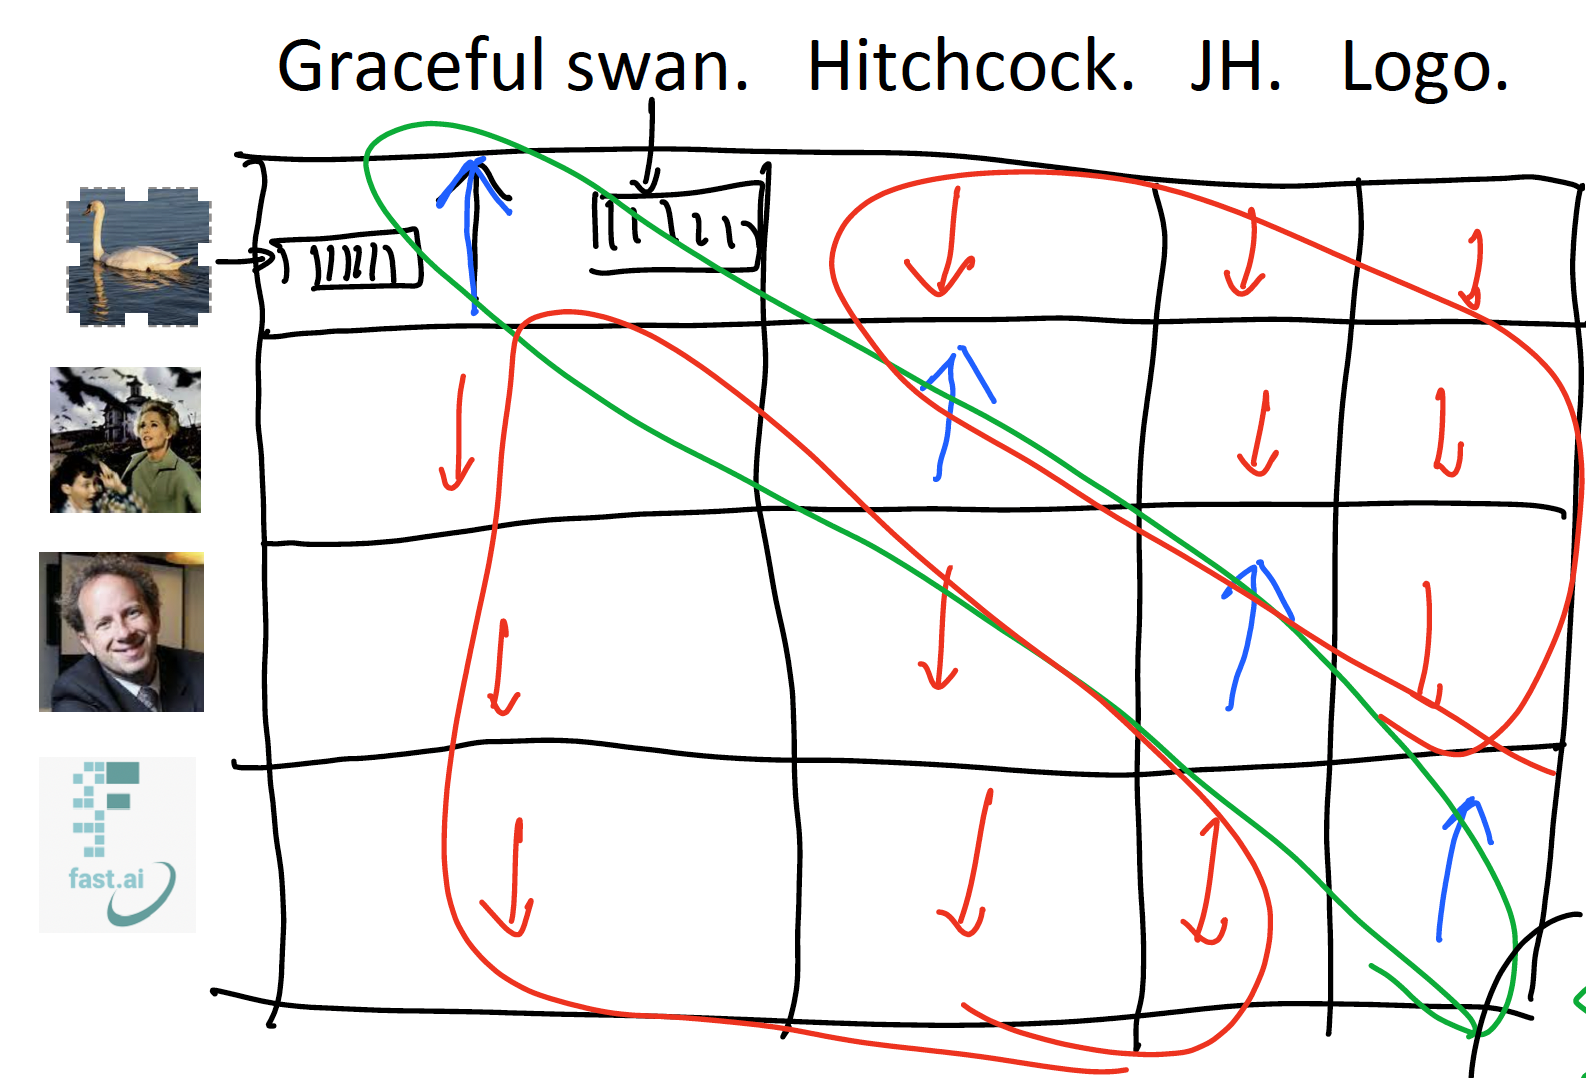

Now, the sum of the off-diagonal elements should be small, and the sum of the diagonal elements should be large. Therefore, we can define a loss function as the sum of the off-diagonal elements minus the sum of the diagonal elements. (Such a loss function would penalise any off-diagonal elements that are large, and penalise any diagonal elements that are small. Conversely, it would reward any off-diagonal elements that are small, and reward any diagonal elements that are large.)

**Note:** Neither contrastive loss, nor perceptual loss are part of `torch.nn`.

27. If we train a model to minimize the contrastive loss, it will learn to output text embeddings that are very similar to the image embeddings. Now imagine we have three phrases: `"Graceful swan."` (seen during training), `"Some beautiful swan"` (not seen during training) and `"Such a lovely swan"` (not seen during training). These should all give embeddings that are very similar to embeddings of images of swans seen during training. **Note:** After the CLIP model is trained, we don't need the image encoder any more. The text encoder has learned to output embeddings that are very similar to what the image encoder would have outputted.

28. We've successfully created two modules that together successfully put text and images into the same feature space. Essentially, contrastive loss is useful for multi-modal applications.

29. Now, if we write `"a cute teddy bear"`, the text can be passed to the CLIP model's text encoder to get a vector representation that's very similar to images of cute teddy bears seen in the training set. This vector representation can now be provided as an input to our UNet (in addition to a noisy latent / a latent comprising pure noise). The CLIP embedding actually gives the UNet a visual hint about what the noise might be.

30. Now we have three components of Stable Diffusion:

- a UNet
- a VAE's decoder
- a CLIP model's text encoder

31. The last question we need to answer is: How exactly do we do the noise removal process (once we have the score function, i.e., once we're able to predict the noise in a noisy latent). Unfortunately, the language used around this is weird & confusing. In particular, the language talks about "*time steps*". This is an overhang of the particular way in which the math was formulated in the first few papers. There are other ways in which we can formulate the math. During this course, we'll avoid using the term "*time steps*". **Note:** "*time steps*" have got nothing to do with time.

32. To see what "*time steps*" are, consider the fact that during the training process, we used varying levels of noise. Some latents were very noisy. Some latents were a bit noisy. Some latents had no noise. And some latents were pure noise. You could create a "*noise schedule*", where along the x-axis, a.k.a. the '*time axis*', you could have the numbers 1 to 1000 (say). You randomly pick a number between 1 and 1000. And you look up the value of noise ('*sigma*' a.k.a. '*beta*') from the noise schedule (a monotonically decreasing function of "*time steps*"). **Note:** '*sigma*' / '*beta*' is the standard deviation of the particular normal distribution from which we sample noise; the means of all the normal distributions are always zero. (In other words, we sample noise from different normal distributions for each training example - the differences are in the standard deviations.) The greater the value of '*sigma*' / '*beta*', the more noisy the latent is going to be.

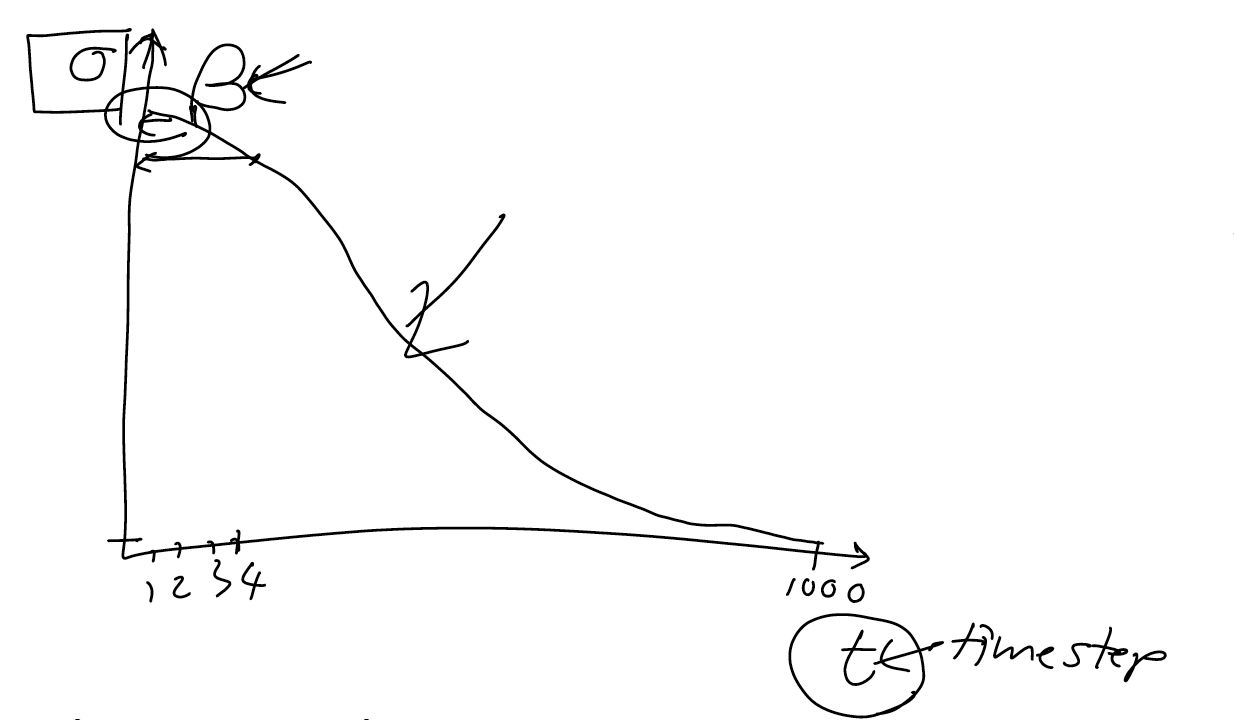

33. These days, people have started to get rid of this notion of a noise schedule altogether. Instead they have started to pick the value of '*sigma*' / '*beta*' directly. (During training, they randomly pick a '*sigma*' / '*beta*' value for each item in a mini-batch, and add it to the latents to create noisy latents, which are then provided as inputs to the UNet.)

34. During inference time, the model is starting with pure noise (or with a somewhat noisy latent in case we're using the image-to-image pipeline). And we want it to be able to predict the de-noised latent. But in practice, it's not able to remove all the noise in one go. Recall the image that we generated in the 'stable_diffusion.ipynb' notebook (in the 'diffusion-nbs' repo) when we set `num_inference_steps=3`. It wasn't anything like an astronaut riding a horse.

35. Instead, if we multiply the predicted noise by some constant `c`, and subtract the product from the noisy latent, and do this a number of times - around 50 times (say), then the diffusion process actually works! In other words, we don't subtract the entire noise predicted by the UNet from the noisy latent at any single inference step. Rather, we multiply the predicted noise by a constant `c`, and subtract it from the noisy latent. And we do this over and over for 50 or so inference steps. **Note:** The constant `c` is kind of like a learning rate, except that we're not updating parameters now; we're updating pixels.

36. Questions like how to choose the value of the constant `c` are decided by the "*diffusion sampler*". But this looks a lot like deep learning optimizers (Momentum, RMSProp, Adam, etc). In a deep learning optimizer, the constant `c` is the learning rate. So concepts such as momentum should be applicable to diffusion samplers as well! This is an area of research that Jeremy is exploring. Diffusion models originally came from the world of differential equations. And there are a whole lot of parallel concepts in the two worlds of (a) optimizers and (b) differential equations. And so, differential equation solvers use a lot of the same kinds of ideas that deep learning optimizers use. One thing that differential equation solvers do is that they tend to take '*time*' as an input. And in fact, pretty much all diffusion models take not just the noisy latent and the prompt as an input, they also take '*time*' as an input. The idea is: the model will be better at removing the noise if you tell it how much noise still exists. Jeremy very strongly suspects that this premise is incorrect, because figuring out how noisy an image is should be very straightforward for a fancy neural net. (**Idea:** Train a separate regression model to do this, i.e., predict how much noise there is. Or maybe use an auxilliary target in the same neural net.) So Jeremy very much doubts that we actually need to pass in '*time*' as an input. And as soon as you stop doing that, things stop looking like differential equations, and they start looking like optimizers.

**Note:** The diffusion sampler is not the same thing as the noise schedule. However, both are dependent on the notion of '*time*'.

37. One last thing: We decided that the loss function of the UNet is MSE. The truth is, in statistics & ML, every time you see somebody use MSE, it's because the math worked out easier that way. What if we replaced MSE with more sophisticated loss functions like "*perceptual loss*"? This loss function tells us: after removing noise from a noisy latent, how good is the noisy latent? Does it look like a (compressed) digit? Does it have the qualities of a (compressed) digit?